In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.


# data preprocess

In [2]:
os.chdir("..")

In [3]:
os.listdir()

['.git',
 '.gitignore',
 'data',
 'notebooks',
 'README.md',
 'requirements.txt',
 'summary_report.pdf',
 'venv',
 'visuals']

In [4]:
data = pd.read_csv('data/data.csv', encoding='latin1')  # ตอนนี้ไฟล์อยู่ตรงนี้
print(data.shape)        # ดูขนาดข้อมูล (rows, columns)
print(data.columns)      # ดูชื่อคอลัมน์
data.head()              # ดูตัวอย่างข้อมูล 5 แถวแรก
data.info()              # ดู type และ null ของแต่ละคอลัมน์


(541909, 8)
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# ดูจำนวน missing values
print(data.isnull().sum())

# ลบแถวที่ CustomerID ว่าง (ทำ customer analysis)
df = data.dropna(subset=['CustomerID'])

# แปลง CustomerID เป็น string 
df['CustomerID'] = df['CustomerID'].astype(str)
data['CustomerID'] = df['CustomerID'].astype(str)


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [6]:
df['Description'] = df['Description'].fillna('Unknown')
data['Description'] = data['Description'].fillna('Unknown')

In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [8]:
# ลบแถวที่ Quantity หรือราคา UnitPrice น้อยกว่าหรือเท่ากับ 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# ผลรวมข้อมูล
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [9]:
#ตรวจสอบข้อมูลซ้ำซ้อน
df.duplicated().sum()  # จำนวนข้อมูลซ้ำ
data.duplicated().sum()

df = df.drop_duplicates()
data = data.drop_duplicates()


# Customer Segments (RFM)

In [10]:
print(df.shape)#customer analysis
print(data.shape)#transaction-level

(392692, 9)
(524878, 9)


กำหนดวันอ้างอิงวิเคราะห์

In [11]:
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

สร้างตาราง RFM

In [12]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,     # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


สร้าง RFM Score

In [13]:
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

แบ่งกลุ่มลูกค้าจากคะแนน

In [14]:
def segment_customer(score):
    if score >= '444':
        return 'Top Customers'
    elif score >= '344':
        return 'Loyal Customers'
    elif score >= '244':
        return 'Potential Loyalist'
    elif score >= '144':
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)


ดูผลลัพธ์

In [15]:
print(rfm[['CustomerID', 'RFM_Score', 'Segment']].head())

# ดูจำนวนลูกค้าแต่ละกลุ่ม
print(rfm['Segment'].value_counts())

# สรุปยอดขายต่อกลุ่ม
print(df.merge(rfm, on='CustomerID').groupby('Segment')['TotalPrice'].sum())


  CustomerID RFM_Score             Segment
0    12346.0       115             At Risk
1    12347.0       555       Top Customers
2    12348.0       244  Potential Loyalist
3    12349.0       414     Loyal Customers
4    12350.0       112             At Risk
Segment
Top Customers         1278
At Risk                836
Potential Loyalist     767
Loyal Customers        734
Needs Attention        723
Name: count, dtype: int64
Segment
At Risk                502449.091
Loyal Customers       1023619.261
Needs Attention        492110.992
Potential Loyalist     698037.980
Top Customers         6170991.570
Name: TotalPrice, dtype: float64


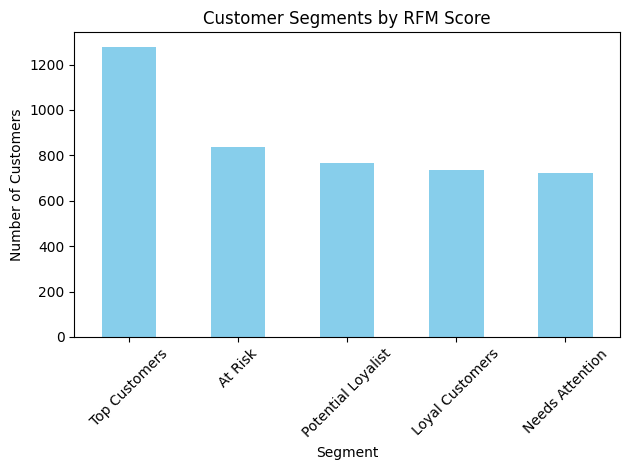

In [16]:
rfm['Segment'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Customer Segments by RFM Score')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Clustering

In [18]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# สมมติว่าคุณมี df RFM แล้ว
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
#Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [ ]:
#หา K ที่ดีที่สุดด้วย Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to choose optimal k')
plt.show()


In [ ]:
#KMeans Clustering
k = 4  # ปรับตามที่ได้จาก elbow
kmeans = KMeans(n_clusters=k, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [ ]:
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

In [ ]:
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments by Recency and Monetary')
plt.show()

จะได้กลุ่มลูกค้า 4 กลุ่ม (Cluster 0, 1, 2, 3) ซึ่งสามารถตีความได้ว่า:

Cluster 0: ลูกค้าใหม่ / ลูกค้าขาจร

Cluster 1: ลูกค้าที่มีการซื้อซ้ำ

Cluster 2: ลูกค้าที่ใช้จ่ายสูง

Cluster 3: ลูกค้าหายไป (ไม่ได้กลับมานาน)